In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurolib.models.hopf import HopfModel
import neurolib.utils.functions as func
plt.rcParams['image.cmap'] = 'plasma'

In [2]:
model = HopfModel()
model.params['duration'] = 1.0*1000
model.params['sigma_ou'] = 0.03

model.run()

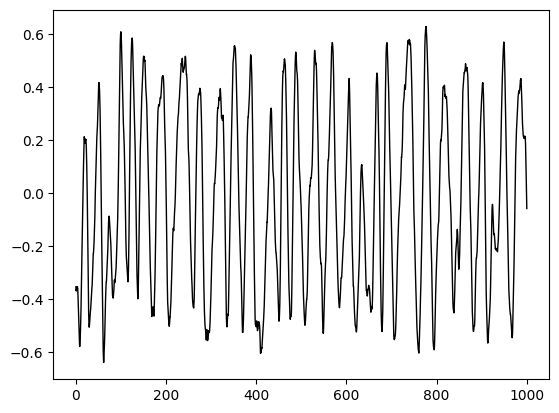

In [3]:
plt.plot(model.t, model.x.T, c = 'k', lw = 1);

Text(0, 0.5, 'Min / max x')

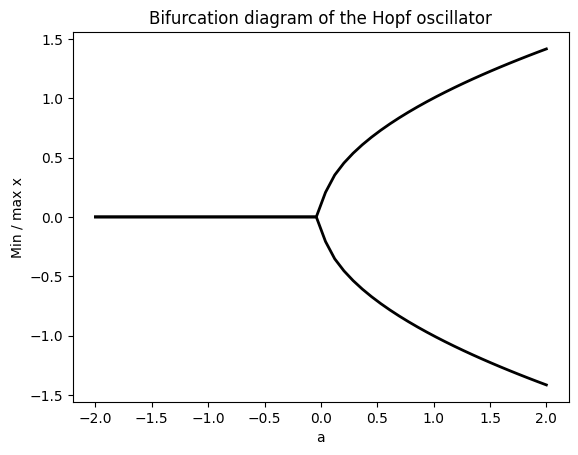

In [4]:
model.params['duration'] = 2.0 * 1000
model.params['sigma_ou'] = 0
max_x = []
min_x = []
a_s = np.linspace(-2, 2, 50)

for a in a_s:
    model.params['a'] = a
    model.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_x.append(np.max(model.x[0, -int(1000/model.params['dt']):]))
    min_x.append(np.min(model.x[0, -int(1000/model.params['dt']):]))

plt.plot(a_s, max_x, c='k', lw = 2)
plt.plot(a_s, min_x, c='k', lw = 2)
plt.title("Bifurcation diagram of the Hopf oscillator")
plt.xlabel("a")
plt.ylabel("Min / max x")

Text(0.5, 0, 't [ms]')

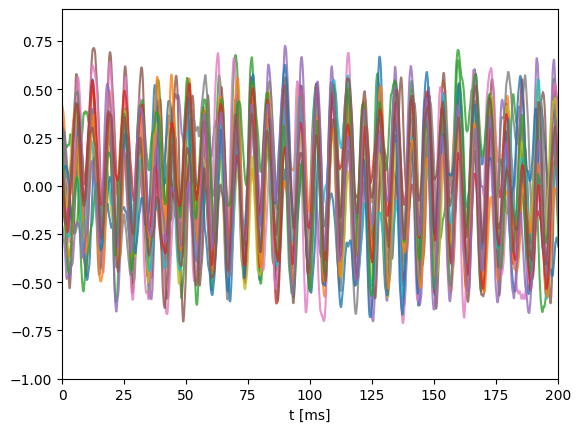

In [5]:
from neurolib.utils.loadData import Dataset
ds = Dataset('hcp')

model = HopfModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['w'] = 1.0
model.params['signalV'] = 0
model.params['duration'] = 20 * 1000 
model.params['sigma_ou'] = 0.13
model.params['K_gl'] = 0.6

model.run(chunkwise=True)

plt.plot(model.t, model.x[::5, :].T, alpha=0.8);
plt.xlim(0, 200)
plt.xlabel("t [ms]")

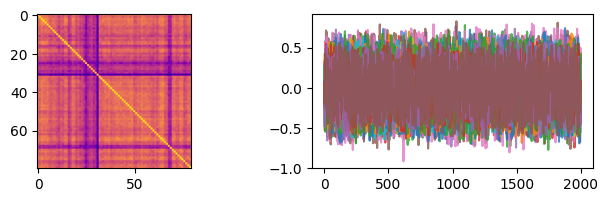

In [6]:
fig, axs = plt.subplots(1,2, figsize = (8,2))
axs[0].imshow(func.fc(model.x[:, -10000:]))
axs[1].plot(model.t, model.x[::5, :].T, alpha=0.8);

In [7]:
scores = [func.matrix_correlation(func.fc(model.x[:, -int(5000/model.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Correlation per subject: ['0.49', '0.48', '0.46', '0.6', '0.47', '0.57', '0.63']
Mean FC/FC correlation: 0.53


In [8]:
a_s = np.arange(-0.2, 0.2, 0.05)
scores = []
for a in a_s:
    model.params['a'] = a
    model.run(chunkwise=True)
    scores.append([func.matrix_correlation(func.fc(model.x[:, -int(5000/model.params['dt']):]), fcemp) for fcemp in ds.FCs])

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.utils.functions import fc, matrix_correlation, ts_kolmogorov
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.loadData import Dataset
from neurolib.models.hopf import HopfModel

ds = Dataset('hcp')
model = HopfModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['duration'] = 1 * 60.0 * 1000
model.params['a'] = -0.05
model.params['K_gl'] = 2.5


def fmri_fit(model):
    t_BOLD = model.BOLD.t_BOLD > 10000
    sim_BOLD = model.x[:, t_BOLD]
    fits = {}
    fits['fc'] = np.mean([matrix_correlation(fc(sim_BOLD), f) for f in ds.FCs])
    fits['fcd'] = np.mean([ts_kolmogorov(sim_BOLD, b) for b in ds.FCDs])
    return fits

def evaluate(traj):
    model = search.getModelFromTraj(traj)
    model.run(chunkwise=True, bold = True)
    fits = fmri_fit(model)

parameters = ParameterSpace({'K_gl': [0.0, 1.0], 'sigma_ou': [0., 1.]})
search = BoxSearch(model, parameters, evaluate)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 2
MainProcess root INFO     BoxSearch: Environment initialized.


In [4]:
ds = Dataset('hcp')

G = 1000

model = HopfModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['duration'] = 1 * 60.0 * 1000
model.params['a'] = -0.05
model.params['K_gl'] = 2.5
model.params['Cmat'] = G * model.params['Cmat']

MainProcess root INFO     Loading dataset hcp from /home/riccardo/anaconda3/envs/neurolib/lib/python3.9/site-packages/neurolib-0.6.1-py3.9.egg/neurolib/utils/../data/datasets/hcp.
MainProcess root INFO     Dataset hcp loaded.
MainProcess root INFO     hopf: Model initialized.


In [5]:
model.params['Cmat']

array([[  0.        ,  79.06337996, 207.67269135, ...,   0.61313653,
         36.21139831,   1.27438684],
       [ 79.06337996,   0.        ,  21.07246223, ...,   1.9140456 ,
          0.83844534,  20.56659983],
       [207.67269135,  21.07246223,   0.        , ...,   1.06482629,
         13.15563689,   2.41510892],
       ...,
       [  0.61313653,   1.9140456 ,   1.06482629, ...,   0.        ,
          1.9214754 , 162.60376111],
       [ 36.21139831,   0.83844534,  13.15563689, ...,   1.9214754 ,
          0.        ,   4.13606228],
       [  1.27438684,  20.56659983,   2.41510892, ..., 162.60376111,
          4.13606228,   0.        ]])

In [12]:
sim_BOLD = model.BOLD.BOLD[:, t_bold]

Text(0.5, 0, 'Time (s)')

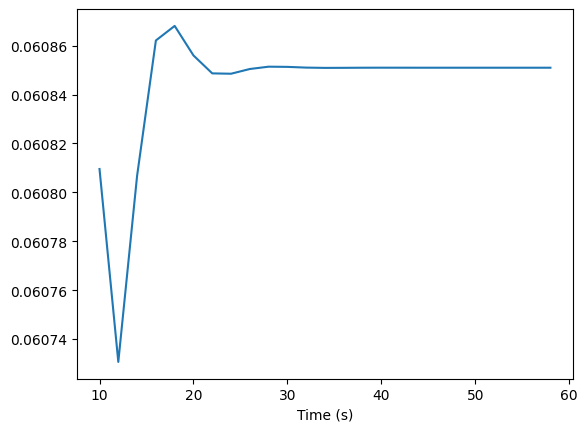

In [13]:
plt.plot((model.BOLD.t_BOLD[t_bold]/1000), sim_BOLD[1]);
plt.xlabel('Time (s)')